In [1]:
import numpy as np
from transformers import (AutoTokenizer, AutoConfig, AutoModel,
                          DataCollatorWithPadding, get_scheduler)
from transformers.modeling_outputs import SequenceClassifierOutput
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from tqdm.auto import tqdm

In [2]:
MODEL_CHECKPOINT = "cointegrated/rubert-tiny2"
DATA_PATH = "?"
NUM_CLASSES = 30

In [3]:
dataset = load_dataset(
    "csv",
    data_files = DATA_PATH
)

Generating train split: 0 examples [00:00, ? examples/s]

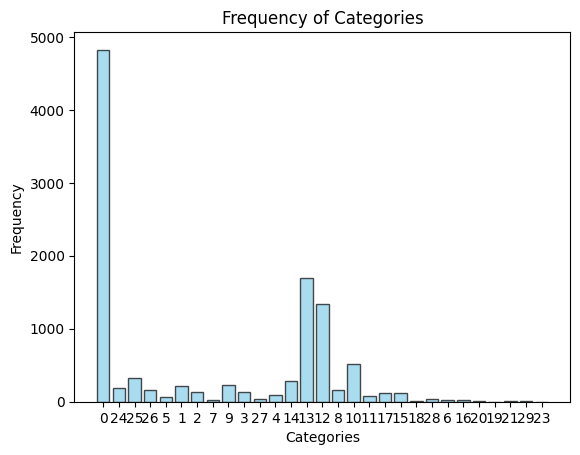

In [4]:
categories = []

for label in dataset["train"]["labels"]:
    if isinstance(label, str):
        categories.append(label.split(", "))

flat_categories = list(itertools.chain.from_iterable(categories))
category_counts = Counter(flat_categories)

labels = list(category_counts.keys())
counts = list(category_counts.values())

plt.bar(labels, counts, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Frequency of Categories')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show()

In [5]:
def one_hotting(example):
    if isinstance(example['labels'], str):
        sep_labels = example['labels'].split(", ")
        one_hot = np.zeros(NUM_CLASSES)
        
        for lbl in sep_labels:
            one_hot[int(lbl)] = 1
        
        example['labels'] = one_hot.tolist()
    return example

mod_dataset = dataset.map(one_hotting)

Map:   0%|          | 0/7768 [00:00<?, ? examples/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
def preprocess_function(examples):
    return tokenizer(examples["texts"], truncation=True, padding=True)

encoded_dataset = mod_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/7768 [00:00<?, ? examples/s]

In [9]:
split_dataset = encoded_dataset["train"].train_test_split(train_size=0.7, seed=42)
split_dataset.set_format("torch",columns=["input_ids",
                                          "token_type_ids",
                                          "attention_mask", 
                                          "labels"])

In [10]:
collater = DataCollatorWithPadding(
    tokenizer=tokenizer,
    pad_to_multiple_of=True
)

In [11]:
train_dataloader = DataLoader(
    split_dataset["train"], shuffle=True, batch_size=10, collate_fn=collater
)
eval_dataloader = DataLoader(
    split_dataset["test"], batch_size=10, collate_fn=collater
)

In [12]:
rubert_model = AutoModel.from_pretrained(MODEL_CHECKPOINT,
                                         trust_remote_code=True,
                                        config=AutoConfig.from_pretrained(MODEL_CHECKPOINT,
                                                                          return_unused_kwargs=True,
                                                                          output_hidden_states=True))

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

In [13]:
class CustomModel(nn.Module):
    def __init__(self, model, num_labels):
        super(CustomModel,self).__init__()
        self.num_labels = num_labels
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(model.config.hidden_size,num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        outputs = self.model(input_ids=input_ids,
                             attention_mask=attention_mask,
                             token_type_ids=token_type_ids)
        pooled_output = outputs.last_hidden_state
        x = self.dropout(pooled_output)
        logits = self.classifier(x[:, 0, :].view(-1,self.model.config.hidden_size))
        
        loss=None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
        
        return SequenceClassifierOutput(loss=loss, logits=logits)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel(rubert_model,NUM_CLASSES).to(device)

In [21]:
num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [17]:
roc_auc = load_metric("roc_auc", "multilabel",
                     trust_remote_code=True)
f1 = load_metric("f1", trust_remote_code=True)

/tmp/ipykernel_36/1560071882.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  roc_auc = load_metric("roc_auc", "multilabel",


In [22]:
progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))


for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        progress_bar_train.update(1)
    
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        activation = torch.sigmoid(logits)
        predictions = (activation >= 0.5).float()
        for indx in range(activation.shape[0]):
            f1.add_batch(predictions=predictions[indx],
                         references=batch["labels"][indx])
            
        roc_auc.add_batch(prediction_scores=activation, 
                        references=batch["labels"])
        progress_bar_eval.update(1)
    
    print(f"{roc_auc.compute(average='samples')} \
          - {f1.compute(average='binary')}")

  0%|          | 0/5440 [00:00<?, ?it/s]

  0%|          | 0/2340 [00:00<?, ?it/s]

{'roc_auc': 0.975370092167027}           - {'f1': 0.7961743493258074}
{'roc_auc': 0.9751393633739919}           - {'f1': 0.7952941176470588}
{'roc_auc': 0.9751920072872453}           - {'f1': 0.7956651484215486}
{'roc_auc': 0.9754358948007918}           - {'f1': 0.7951655940982578}
{'roc_auc': 0.9751094389689536}           - {'f1': 0.7947227893827548}
{'roc_auc': 0.9749046497050511}           - {'f1': 0.7945334590009424}
{'roc_auc': 0.9753022675462012}           - {'f1': 0.7955402010050251}
{'roc_auc': 0.9751302838934658}           - {'f1': 0.7954830614805521}
{'roc_auc': 0.9752376116249497}           - {'f1': 0.7958510136727958}
{'roc_auc': 0.9753124328167205}           - {'f1': 0.795668549905838}


In [27]:
result = []
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    activation = torch.sigmoid(logits)
    predictions = (activation >= 0.5).float()
    for indx in range(activation.shape[0]):
        result.append(f1.compute(predictions=predictions[indx], 
                                 references=batch["labels"][indx],
                                 average="macro")["f1"])
        
category_counts = Counter(result)
category_counts